In [131]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, least_squares
from scipy.stats import norm
from openpyxl import Workbook, load_workbook, utils
from openpyxl.styles import Alignment, Font
import string

### Functions

In [132]:
def trim(X, percent):
    ''' Trims X with the percent input by finding the top and bottom 
    (percent/2) observations and then returns a matrix of binary variables 
    indicating rows of X that would not be trimmed
    '''
    
    alpha = (1 - percent)/2
    n, k = np.shape(X)
    t_ind = np.zeros((n, k))
    
    for i in range(0, k):
        upper_bd = np.percentile(X[:,i], (1 - alpha)*100)
        lower_bd = np.percentile(X[:,i], (alpha)*100)
        t_ind[:, i] = [int(lower_bd < x < upper_bd) for x in X[:,i]]
        
    return np.prod(t_ind, axis = 1)


def CE_1(Y, X, arg, r):
    ''' Conditional Expectation of Y given X at arg (matrix) with bandwith r 
    using a gaussian kernel 
    '''

    n_arg = np.shape(arg)[0]
    n = np.shape(X)[0]
    h = (n**(-r)) * np.std(X, axis = 0, ddof = 1)
    e = np.zeros((n_arg, 1))
    
    for j in range(0, n_arg):
        k = np.divide(norm.pdf(np.divide((arg[j] - X), h)), h)
        k = np.prod(k, axis = 1)   
        e[j] = (Y.T*k/n)/np.mean(k)
        
    return e


def SLS_1(b, Y, X, X_ind):
    ''' Semiparametric least-squares using CE_1 and bandwith = 1/5
    '''
    
    v = X * np.matrix(b).T
    EY = CE_1(Y, v, v, 1/5)
    residual = np.power((Y - EY), 2)
    
    return (-0.5 * np.matrix(X_ind)*residual)


# Regress Y on X with SLS
def run_semiparametric_regression(Y, X, guess, trim_percent = 0.98, 
    xtol = 0.001, maxiter = 1):
    ''' Runs SLS with some default parameters, approximates an initial guess 
    using BFGS
    '''
    
    obj_f = lambda x_0: -1e6*SLS_1(np.append(np.array([1]), x_0), Y, X, 
        trim(X, 0.98))[0,0]

    print('    Running LS...')
    result = least_squares(obj_f, list(np.array(guess).flatten()), xtol = xtol)

    print('    BFGS...')
    result = minimize(obj_f, list(np.array(guess).flatten()), method='BFGS', 
        options = {'maxiter': maxiter})

    return result


def convert_hessian_to_cov(Y, X, results):
    ''' Converts the result output from scipy.optimize into a covariance matrix 
    by taking the inverse of the hessian and multiplying by an estimate of the 
    variance of the residuals 
    '''
    
    sigma_2_hat = np.mean(np.power(Y - X*np.matrix(results.x).T, 2))
    return results.hess_inv * sigma_2_hat


def compute_marginal_effect(Y, X, ind, point, beta, delta = 0.01):
    ''' Finds the marginal effects at a given point using CE_1, delta 
    represents the amount to nudge the point by when calculating the marginal 
    effects, ind refers to the index of the variable being nudged
    '''

    point_nudge = np.copy(point)
    point_nudge[0, ind] = point_nudge[0, ind] + delta
    point_nudge = np.matrix(point_nudge)
    
    v_hat = X*beta
    v_hat_avg = point*beta
    v_hat_avg_nudge = point_nudge*beta
    
    return np.asscalar(CE_1(Y, v_hat, v_hat_avg_nudge, 1/5) - 
        CE_1(Y, v_hat, v_hat_avg, 1/5))/delta


def find_tstats(Y, X, results):
    ''' Computes t_stats using an input of variables and the results 
    of a scipy.minimize routine (must output a hessian)
    '''
    
    V = convert_hessian_to_cov(Y, X, results)

    n = np.shape(results.x)[0]
    theta = results.x/results.x[0]
    t_stats = np.zeros(shape = (n))
    t_stats[0] = np.nan # first t-stat is unknown

    for i in range(1, n):
        t_stats[i] = theta[i] / np.sqrt(V[i,i])

    return t_stats    

def get_sig_stars(coeff, stderr, p_value_labels):
    ''' Outputs significance stars after calculating the t-stat 
    '''
    t_stat = coeff/stderr
    p_val  = 2*(1 - norm.cdf(np.abs(t_stat)))
    below_ind = np.where([p_val < x for x in p_value_labels.keys()])[0]
    below_vals = [list(p_value_labels.keys())[i] for i in below_ind]
    if not below_vals:
        return ''
    else:
        min_p_val = np.min(below_vals)
        return p_value_labels[min_p_val]

# Unpaid

### Params

In [118]:
data_dmd_loc = '../data/processed/regression_data_levels_demeaned.csv'

output_file_loc  = '../analysis/results/nls_'
output_file_name = 'unpaid_market'#input('Enter file name: ')
workbook_file_loc = output_file_loc + output_file_name + '.xlsx'

sample_query = 'Rebate_Dummy == 0 & OrderType == "Market"'#input('Enter data query: ')

# 'nudge length' for calculating marginal effects
delta = .001

# params for optimization routines
reg_xtol = 0.01
reg_maxiter = 10

p_value_labels = {0.05: '*', 0.01: '**', 0.001: '***'}

In [119]:
print(workbook_file_loc)
print(sample_query)

../analysis/results/nls_unpaid_market.xlsx
Rebate_Dummy == 0 & OrderType == "Market"


### Main

In [120]:
## Load data

data_df = pd.read_csv(data_dmd_loc)
data_df['PrImp_Pct_Rebate_Dummy'] = data_df['PrImp_Pct'] * \
                                        data_df['Rebate_Dummy']
data_df['PrImp_AvgAmt_Rebate_Dummy'] = data_df['PrImp_AvgAmt'] * \
                                         data_df['Rebate_Dummy']
data_df['PrImp_ExpAmt_Rebate_Dummy'] = data_df['PrImp_ExpAmt'] * \
                                         data_df['Rebate_Dummy']
data_df['PrImp_AvgT_Rebate_Dummy'] = data_df['PrImp_AvgT'] * \
                                         data_df['Rebate_Dummy']
data_df['All_AvgT_Rebate_Dummy'] = data_df['All_AvgT'] * \
                                         data_df['Rebate_Dummy']

## Information about sample

sample_frac = 1 # None => All obs
data_df = data_df.sample(frac = sample_frac).query(sample_query)

print('Market Centers: ', end = '') 
print(data_df['MarketCenter'].unique())

print('Brokers: ', end = '') 
print(data_df['Broker'].unique())

print('Exchanges: ', end = '') 
print(data_df['Exchange'].unique())

print('OrderTypes: ', end = '') 
print(data_df['OrderType'].unique())

print('Samples: %d' % data_df.shape[0])
print('Sparsity: %0.2f%%' % 
    (100*data_df.query('MktShare == 0').shape[0] / data_df.shape[0]))


## Regressions

# Fits
fit1_formula = 'MktShare ~ PrImp_Pct + PrImp_AvgAmt + PrImp_AvgT'
fit2_formula = 'MktShare ~ PrImp_ExpAmt + PrImp_AvgT'
fit3_formula = 'MktShare ~ PrImp_Pct + PrImp_AvgAmt + All_AvgT'
fit4_formula = 'MktShare ~ PrImp_ExpAmt + All_AvgT'

formulaCols = lambda x: x.replace(' ', '').replace('~', '+').split('+') 
fit_formulae = [fit1_formula, fit2_formula, fit3_formula, fit4_formula]
fit_formulae = [formulaCols(x) for x in fit_formulae]

# Store results
fit_results = [None] * len(fit_formulae)


## Get Results
for i in range(0, len(fit_formulae)):
    
    ## Get results
    print('Regressing with fit %d...' % i )
    
    data = data_df[fit_formulae[i]].dropna()
    X = np.matrix(data)[:, 1:]
    Y = np.matrix(data)[:, 0]

    beta_guess, _, _ , _ = np.linalg.lstsq(X, Y, rcond = -1)
    results = run_semiparametric_regression(Y, X, 
        beta_guess[1:]/beta_guess[0], xtol = 0.00001, maxiter = 50)
    
    fit_results[i] = results
    
    ## Update results
    # Normalize results with first coefficient
    fit_results[i].x = np.append(1, fit_results[i].x)
    
    # Add dictionary of coefficients 
    fit_results[i].coeffs  = {fit_formulae[i][1:][j]: fit_results[i].x[j] for 
        j in range(0, len(fit_formulae[i])-1)}
    
    # Add dictionary of standard errors 
    V = convert_hessian_to_cov(Y, X, fit_results[i])
    fit_results[i].stderrs = {fit_formulae[i][1:][j]: np.sqrt(V[j-1,j-1]) for 
        j in range(1, len(fit_formulae[i])-1)}
    fit_results[i].stderrs[fit_formulae[i][1:][0]] = np.nan
    
print('Complete')  


## Marginal Effects

for i in range(0, len(fit_formulae)):
    
    data = data_df[fit_formulae[i]]
    X = np.matrix(data)[:, 1:]
    Y = np.matrix(data)[:, 0]
    
    fit_results[i].marginal_effects = {}
    
    for j in range(0, len(fit_results[i].x)):  
        
        temp_dict = {}
        
        for percentile in range(20, 81, 20):

            X_percentile = np.percentile(X, percentile, axis = 0)
            
            temp_dict[percentile] = compute_marginal_effect(Y, X, j, 
                np.matrix(X_percentile), np.matrix(fit_results[i].x).T, 
                delta = delta)
            
        fit_results[i].marginal_effects[fit_formulae[i][j+1]] = temp_dict

Market Centers: ['UBSS' 'FBCO' 'SGMA' 'BNYC' 'CDRG' 'G1ES' 'VRTU' 'WOLV']
Brokers: ['Insigneo Securities' 'AXA' 'Edward Jones' 'Dakota Securities'
 'Florida Atlantic' 'BMO Capital' 'Aurora Capital' 'Bank of the West'
 'LPL' 'Benjamin Jerold' 'Elish Elish' 'Euro Pacific Capital'
 'Bull Market Securities' 'Fifth Third']
Exchanges: ['Other' 'NYSE' 'NASDAQ']
OrderTypes: ['Market']
Samples: 1488
Sparsity: 1.61%
Regressing with fit 0...
    Running LS...
    BFGS...
Regressing with fit 1...
    Running LS...
    BFGS...
Regressing with fit 2...
    Running LS...
    BFGS...
Regressing with fit 3...
    Running LS...
    BFGS...
Complete


In [125]:
fit_results_unpaid = fit_results

# Paid

### Params

In [127]:
data_dmd_loc = '../data/processed/regression_data_levels_demeaned.csv'

output_file_loc  = '../analysis/results/nls_'
output_file_name = 'paid_market'#input('Enter file name: ')
workbook_file_loc = output_file_loc + output_file_name + '.xlsx'

sample_query = 'Rebate_Dummy == 1 & OrderType == "Market"'#input('Enter data query: ')

# 'nudge length' for calculating marginal effects
delta = .001

# params for optimization routines
reg_xtol = 0.01
reg_maxiter = 10

p_value_labels = {0.05: '*', 0.01: '**', 0.001: '***'}

In [128]:
print(workbook_file_loc)
print(sample_query)

../analysis/results/nls_paid_market.xlsx
Rebate_Dummy == 1 & OrderType == "Market"


### Main

In [129]:
## Load data

data_df = pd.read_csv(data_dmd_loc)
data_df['PrImp_Pct_Rebate_Dummy'] = data_df['PrImp_Pct'] * \
                                        data_df['Rebate_Dummy']
data_df['PrImp_AvgAmt_Rebate_Dummy'] = data_df['PrImp_AvgAmt'] * \
                                         data_df['Rebate_Dummy']
data_df['PrImp_ExpAmt_Rebate_Dummy'] = data_df['PrImp_ExpAmt'] * \
                                         data_df['Rebate_Dummy']
data_df['PrImp_AvgT_Rebate_Dummy'] = data_df['PrImp_AvgT'] * \
                                         data_df['Rebate_Dummy']
data_df['All_AvgT_Rebate_Dummy'] = data_df['All_AvgT'] * \
                                         data_df['Rebate_Dummy']

## Information about sample

sample_frac = 1 # None => All obs
data_df = data_df.sample(frac = sample_frac).query(sample_query)

print('Market Centers: ', end = '') 
print(data_df['MarketCenter'].unique())

print('Brokers: ', end = '') 
print(data_df['Broker'].unique())

print('Exchanges: ', end = '') 
print(data_df['Exchange'].unique())

print('OrderTypes: ', end = '') 
print(data_df['OrderType'].unique())

print('Samples: %d' % data_df.shape[0])
print('Sparsity: %0.2f%%' % 
    (100*data_df.query('MktShare == 0').shape[0] / data_df.shape[0]))


## Regressions

# Fits
fit1_formula = 'MktShare ~ PrImp_Pct + PrImp_AvgAmt + PrImp_AvgT'
fit2_formula = 'MktShare ~ PrImp_ExpAmt + PrImp_AvgT'
fit3_formula = 'MktShare ~ PrImp_Pct + PrImp_AvgAmt + All_AvgT'
fit4_formula = 'MktShare ~ PrImp_ExpAmt + All_AvgT'

formulaCols = lambda x: x.replace(' ', '').replace('~', '+').split('+') 
fit_formulae = [fit1_formula, fit2_formula, fit3_formula, fit4_formula]
fit_formulae = [formulaCols(x) for x in fit_formulae]

# Store results
fit_results = [None] * len(fit_formulae)


## Get Results
for i in range(0, len(fit_formulae)):
    
    ## Get results
    print('Regressing with fit %d...' % i )
    
    data = data_df[fit_formulae[i]].dropna()
    X = np.matrix(data)[:, 1:]
    Y = np.matrix(data)[:, 0]

    beta_guess, _, _ , _ = np.linalg.lstsq(X, Y, rcond = -1)
    results = run_semiparametric_regression(Y, X, 
        beta_guess[1:]/beta_guess[0], xtol = 0.00001, maxiter = 50)
    
    fit_results[i] = results
    
    ## Update results
    # Normalize results with first coefficient
    fit_results[i].x = np.append(1, fit_results[i].x)
    
    # Add dictionary of coefficients 
    fit_results[i].coeffs  = {fit_formulae[i][1:][j]: fit_results[i].x[j] for 
        j in range(0, len(fit_formulae[i])-1)}
    
    # Add dictionary of standard errors 
    V = convert_hessian_to_cov(Y, X, fit_results[i])
    fit_results[i].stderrs = {fit_formulae[i][1:][j]: np.sqrt(V[j-1,j-1]) for 
        j in range(1, len(fit_formulae[i])-1)}
    fit_results[i].stderrs[fit_formulae[i][1:][0]] = np.nan
    
print('Complete')  


## Marginal Effects

for i in range(0, len(fit_formulae)):
    
    data = data_df[fit_formulae[i]]
    X = np.matrix(data)[:, 1:]
    Y = np.matrix(data)[:, 0]
    
    fit_results[i].marginal_effects = {}
    
    for j in range(0, len(fit_results[i].x)):  
        
        temp_dict = {}
        
        for percentile in range(20, 81, 20):

            X_percentile = np.percentile(X, percentile, axis = 0)
            
            temp_dict[percentile] = compute_marginal_effect(Y, X, j, 
                np.matrix(X_percentile), np.matrix(fit_results[i].x).T, 
                delta = delta)
            
        fit_results[i].marginal_effects[fit_formulae[i][j+1]] = temp_dict

Market Centers: ['UBSS' 'CDRG' 'FBCO' 'BNYC' 'SGMA' 'G1ES' 'VRTU' 'WOLV']
Brokers: ['Wells Fargo' 'E1 Asset Mgmt' 'INTL FCStone' 'Lightspeed Trading'
 'Barclays Capital' 'Cambria Capital' 'TD Ameritrade' 'Deutsche'
 'Boenning Scattergood' 'Hollencrest Securities' 'Two Sigma'
 'Evercore Group' 'BTIG' 'Inlet Securities' 'JP Morgan' 'Credit Suisse']
Exchanges: ['NYSE' 'Other' 'NASDAQ']
OrderTypes: ['Market']
Samples: 1494
Sparsity: 27.31%
Regressing with fit 0...
    Running LS...
    BFGS...
Regressing with fit 1...
    Running LS...
    BFGS...
Regressing with fit 2...
    Running LS...
    BFGS...
Regressing with fit 3...
    Running LS...
    BFGS...
Complete


In [130]:
fit_results_paid = fit_results

# Marginal Effects

In [99]:
fit_marginal_effects = [None]*len(fit_formulae)

In [110]:
## Marginal Effects

for i in range(0, len(fit_formulae)):
    
    data = data_df[fit_formulae[i]]
    X = np.matrix(data)[:, 1:]
    Y = np.matrix(data)[:, 0]
    
    fit_marginal_effects[i] = {}
    
    for j in range(0, len(fit_results[i].x)):  
        
        temp_results = np.empty((0,2))
        
        for percentile in range(20, 81, 1):
            
            X_percentile = np.percentile(X, percentile, axis = 0)
            
            temp_results = np.append(temp_results, 
                                     [[percentile, compute_marginal_effect(Y, X, j, 
                                                                          np.matrix(X_percentile), np.matrix(fit_results[i].x).T, 
                                                                          delta = delta)]], 
                                     axis = 0)
            
        fit_marginal_effects[i][fit_formulae[i][j+1]] = temp_results 
            
        #fit_results[i].marginal_effects[fit_formulae[i][j+1]] = temp_dict

In [111]:
[None]*4

[None, None, None, None]

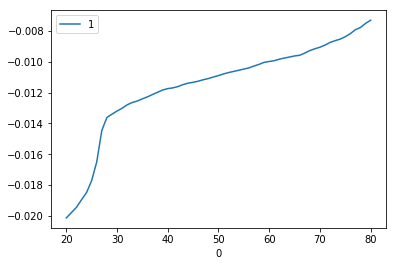

In [112]:
pd.DataFrame(temp_results).set_index(0).plot()

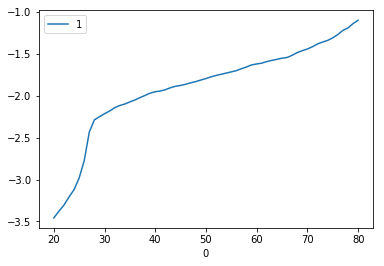

In [124]:
temp = fit_marginal_effects[3]['PrImp_ExpAmt']

pd.DataFrame(temp).set_index(0).plot()

In [148]:
[i.keys() for i in fit_marginal_effects]

[dict_keys(['PrImp_AvgAmt', 'PrImp_AvgT', 'PrImp_Pct']),
 dict_keys(['PrImp_ExpAmt', 'PrImp_AvgT']),
 dict_keys(['All_AvgT', 'PrImp_AvgAmt', 'PrImp_Pct']),
 dict_keys(['All_AvgT', 'PrImp_ExpAmt'])]

# Scratch